# This is an examples of how to perform a mcmc Voigt profile fit to absorption lines


## Written By: Rongmon Bordoloi
Dec 14, 2020
Tested on Python 3.7

In [32]:
#Load modules
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from importlib import reload

from linetools.spectra.xspectrum1d import XSpectrum1D  
import vfit_mcmc as mc

import model as m
reload(m)
reload(mc)

<module 'vfit_mcmc' from '/Users/bordoloi/WORK/python/rbvfit/src/rbvfit/vfit_mcmc.py'>

## Read in the data that you want to fit and prepare data 

In [98]:
#Change this to the continuum normalized spectrum you are using for the fit
filename='/Users/bordoloi/Dropbox/COS-Pairs/Targets/J2228-0950/Data/J2228-0950_nbin3_coadd_wc.fits'
sp=XSpectrum1D.from_file(filename)

In [100]:
#Redshift of the absorber you are trying to fit
zabs=0.464854

wave_full=sp.wavelength.value
flux=sp.flux.value/sp.co.value
error=sp.sig.value/sp.co.value



#Making slices in obsered frame and selecting around two HI lines (1215,1025)
q=np.where(((wave_full/(1.+zabs) >1022.) & (wave_full/(1.+zabs) < 1028.)) | ((wave_full/(1.+zabs) >1210.) & (wave_full/(1.+zabs) < 1220.))
          | ((wave_full/(1.+zabs) >969.) & (wave_full/(1.+zabs) < 975.)))


#Up to this part, and the previous cell, you can replace wiht your own code to read spectra 
#---------------------------------

# The wave,normalzied flux, normalized error arrays used for the fitting process

wave=wave_full[q]
flux=flux[q]
error=error[q]


## Start preparing the model for fitting

In [54]:


    
# . With default 6.5 pixel FWHM of HST/COS and Gaussian convolution

# Absorber redshift to fit
zabs=np.array([zabs])

#Which transitions to fit
lambda_rest = [1215.67,1025.6,972.5368]# * np.ones((len(zabs),))

#Initial guess of clouds
nguess=[16.,14.]
bguess=[20.,20.]
vguess=[0.,-80.]

theta=np.concatenate((nguess,bguess,vguess))

#Setting the upper and lower limits for the fit. You can also do it by hand if you prefer
bounds,lb,ub=mc.set_bounds(nguess,bguess,vguess)

#No of clouds in the fit 
nclump= len(nguess)
#No of transitions going into the fit
ntransition=len(lambda_rest)

print('Preparing model to fit **********')
# I am using a default Gaussian FWHM of 6.5 pixels for HST/COS data, you can replace this with grating, and l
s=m.create_voigt(zabs,lambda_rest,nclump,ntransition=ntransition,FWHM = '6.5')#, grating='G130M',life_position='1'):
y=s.model_flux(theta,wave)
print(' Done Preparing Model ************')


Preparing model to fit **********
 Done Preparing Model ************


## Quick view, how the model looks

<IPython.core.display.Javascript object>


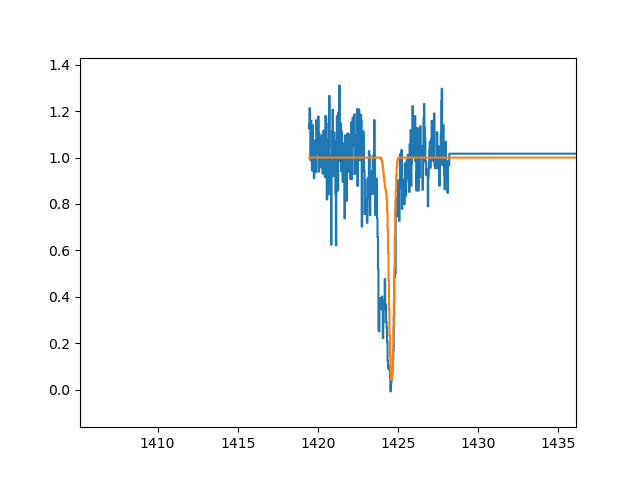

In [55]:

plt.step(wave,flux)
plt.step(wave,y)

## Now run mcmc fitting

In [56]:
t = mc.vfit(s.model_flux, theta, lb, ub, wave, flux, error)
t.runmcmc()


Optimizing Guess ***********
Done ***********
Preparing emcee ***********
Starting emcee ***********


/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Start Burntime Calculations ***********
Done Burning Steps!
Now starting the Final Calculations:
*****************
[##############################]


## Show the posterior distribution of the fitted paramters


<IPython.core.display.Javascript object>


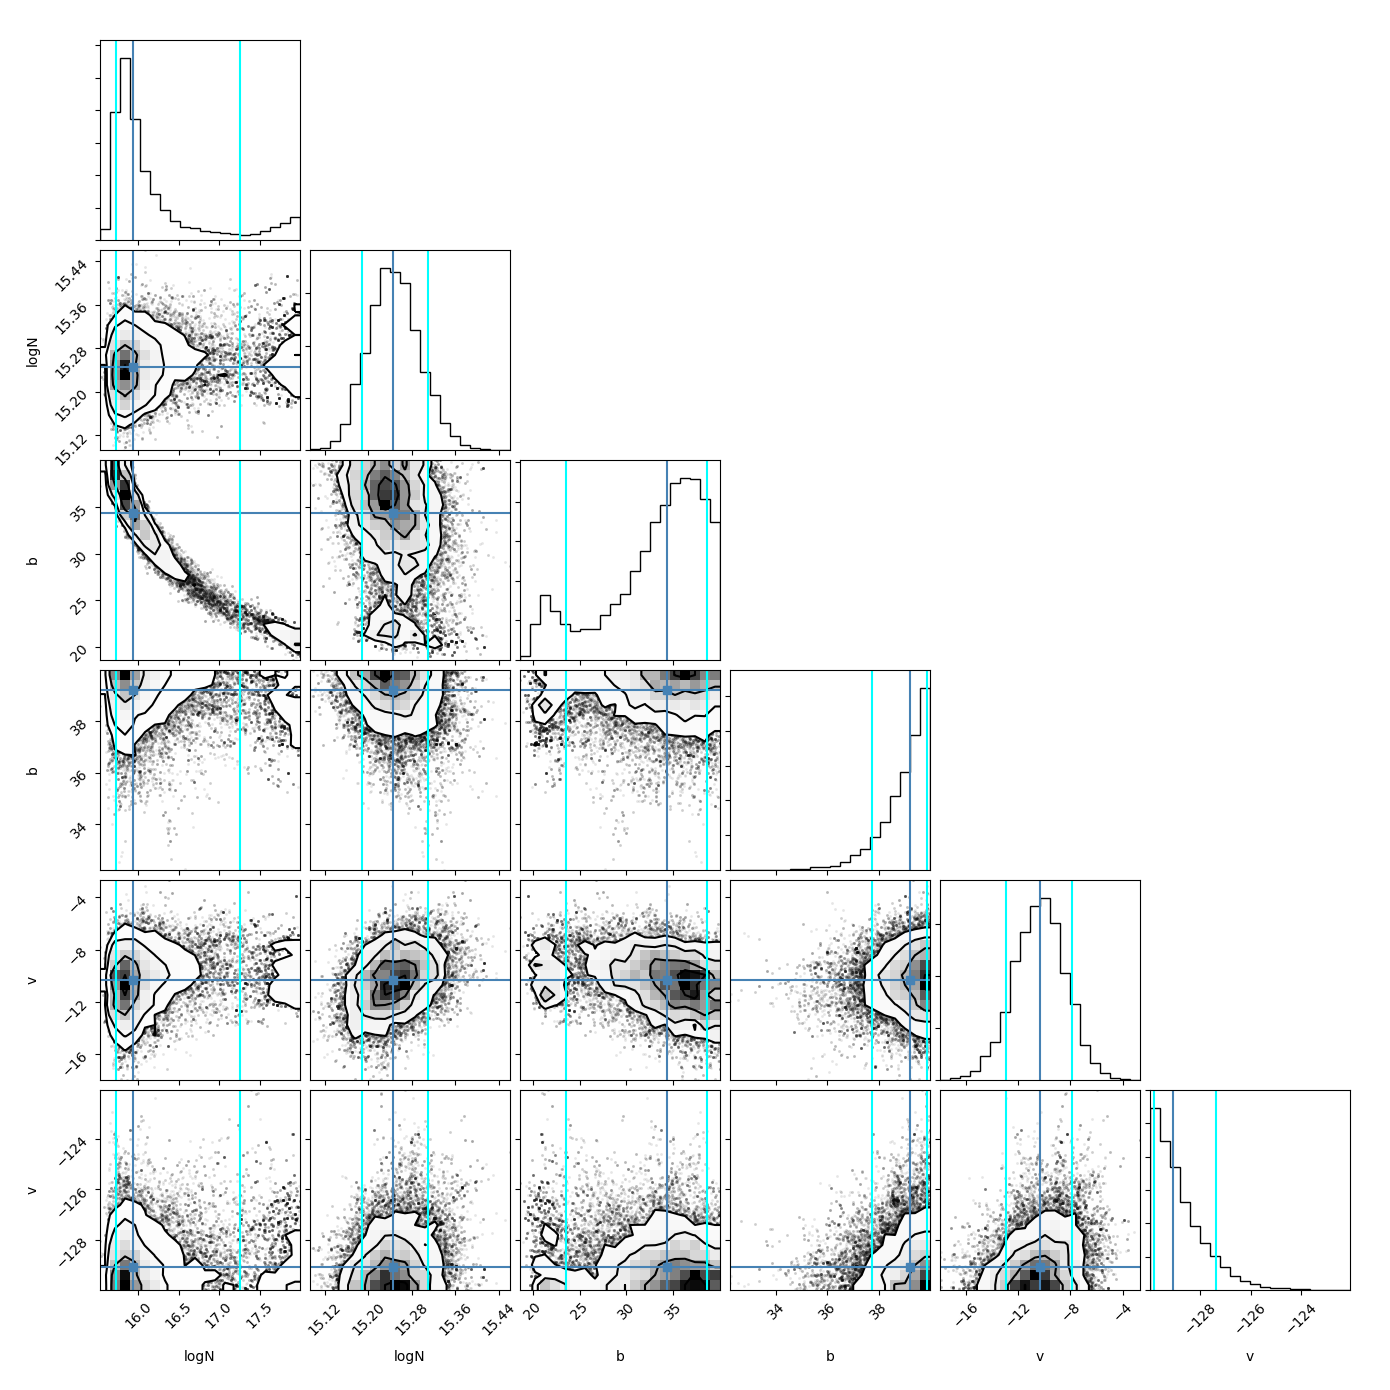

In [57]:
t.plot_corner()

## Extract the best fit paramters 

In [58]:
theta_prime=t.best_theta # Best Fit
theta_low=t.low_theta # lower bound
theta_high=t.high_theta # Upper bound

sample_full= t.samples  # Full Matrix containing the posterior distribution functions


## Plot the model fits

In [96]:
def plot_model(wave_obs,fnorm,enorm,fit,model,outfile= False):

        theta_prime=fit.best_theta
        value1=fit.low_theta
        value2=fit.high_theta

        samples=fit.samples
        model_mcmc=fit.model

        #Now extracting individual fitted components
        best_fit, f1 = model.model_fit(theta_prime, wave_obs)

        fig = plt.figure(figsize=(12, 4))
        BIGGER_SIZE = 18

        plt.step(wave_obs, fnorm, 'k-', linewidth=1.)
        plt.step(wave_obs, enorm, color='r', linewidth=1.)
        index = np.random.randint(0, high=len(samples), size=100)
        
        # Plotting a random sample of outputs extracted from posterior distribution
        for i in range(len(index)):
            plt.plot(wave_obs, model_mcmc(samples[index[i], :], wave_obs), color="k", alpha=0.1)

        plt.ylim([0, 1.6])
        plt.xlim([min(wave_obs),max(wave_obs)])
        
        plt.plot(wave_obs, best_fit, color='b', linewidth=3)
        plt.plot([0., 0.], [-0.2, 2.5], 'k:', lw=0.5)
        n_clump = int(len(theta_prime) / 3)

        best_N = theta_prime[0:n_clump]
        best_b = theta_prime[n_clump:2 * n_clump]
        best_v = theta_prime[2 * n_clump:3 * n_clump]

        low_N = value1[0:n_clump]
        low_b = value1[n_clump:2 * n_clump]
        low_v = value1[2 * n_clump:3 * n_clump]

        high_N = value2[0:n_clump]
        high_b = value2[n_clump:2 * n_clump]
        high_v = value2[2 * n_clump:3 * n_clump]
        
        # plot individual components
        for i in range(0, np.shape(ff)[1]):
            plt.plot(wave_obs, f1[:, i], 'g:', linewidth=3)


        plt.xlabel('Wavelength ', fontsize=18)
        plt.ylabel('Relative Flux', fontsize=18)

        if outfile==False:
            plt.show()
        else:
            outfile_fig =outfile
            fig.savefig(outfile_fig, bbox_inches='tight')




<IPython.core.display.Javascript object>


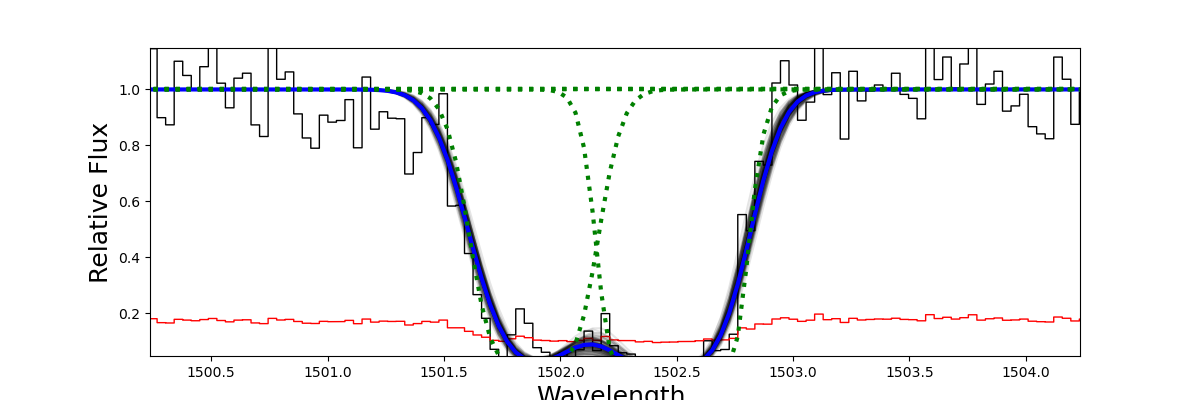

In [97]:
plot_model(wave,flux,error,t,s)

<bound method create_voigt.model_fit of <model.create_voigt object at 0x7f866b691190>>

In [41]:
  for i in range(0, n_clump):
            plt.plot(wave_obs, f1[:, i], 'g:', linewidth=3)



NameError: name 'n_clump' is not defined

In [46]:
len(nguess)

2

In [61]:
dir(s)

['FWHM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'compile_model',
 'grating',
 'kernel',
 'lambda_rest',
 'life_position',
 'line',
 'model_fit',
 'model_flux',
 'model_unconvolved',
 'nclump',
 'ntransition',
 'use_custom_lsf',
 'zabs']

In [64]:
s.ntransition

3

In [73]:
s.line.lines[4].wave0

972.5368

In [74]:
theta_prime

array([  15.93864416,   15.24593516,   34.31274523,   39.23209861,
        -10.33239141, -129.0769569 ])

In [91]:
f,ff=s.model_fit(theta_prime, wave)


6

<IPython.core.display.Javascript object>


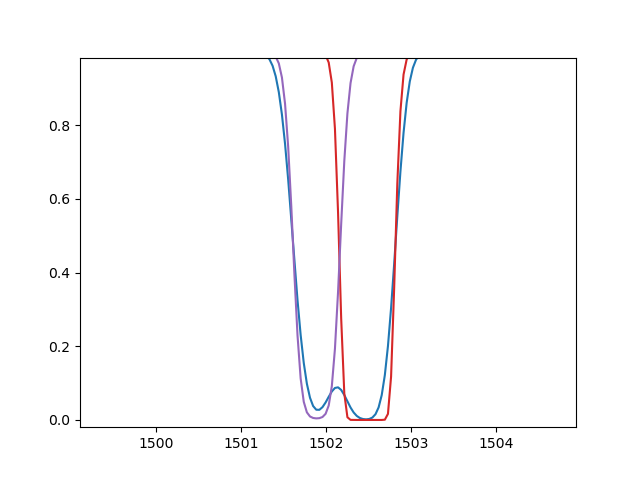

In [83]:
%matplotlib notebook
plt.plot(wave,f)
plt.plot(wave,ff)
